<a href="https://colab.research.google.com/github/stellagerantoni/learning-time-series-counterfactuals/blob/main/multivariate_heandwriten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! git clone https://github.com/stellagerantoni/learning-time-series-counterfactuals
%cd learning-time-series-counterfactuals/

Cloning into 'learning-time-series-counterfactuals'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 330 (delta 134), reused 168 (delta 120), pack-reused 138
Receiving objects: 100% (330/330), 4.98 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/learning-time-series-counterfactuals


In [4]:

!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.1/812.1 kB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
%cd src
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

/content/learning-time-series-counterfactuals/src


In [6]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [29]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data
  if dataset == 'Handwriting':
    return X,y,meta_data
  if dataset =='CharacterTrajectories':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

In [32]:
X, y, meta_data = load_classification('Libras')
print(" Shape of X = ", X.shape)
print(" Shape of y = ", y.shape)
print(" Meta data = ", meta_data)

 Shape of X =  (360, 2, 45)
 Shape of y =  (360,)
 Meta data =  {'problemname': 'libras', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']}


In [33]:
X[1]

array([[0.72147, 0.7234 , 0.7234 , 0.7234 , 0.7234 , 0.71567, 0.67505,
        0.59188, 0.4971 , 0.42747, 0.36944, 0.30948, 0.27853, 0.26306,
        0.26112, 0.25919, 0.27466, 0.30754, 0.37718, 0.46035, 0.55899,
        0.65377, 0.73114, 0.79304, 0.82012, 0.80851, 0.75629, 0.66538,
        0.54932, 0.45841, 0.39458, 0.33849, 0.30754, 0.2882 , 0.28046,
        0.28046, 0.2882 , 0.31141, 0.3675 , 0.44101, 0.52031, 0.59768,
        0.67118, 0.73501, 0.78143],
       [0.23611, 0.23611, 0.23611, 0.23611, 0.23611, 0.2338 , 0.22685,
        0.22685, 0.25   , 0.3125 , 0.38194, 0.49306, 0.62269, 0.71528,
        0.76389, 0.7662 , 0.69676, 0.55787, 0.43056, 0.35185, 0.30556,
        0.29861, 0.2963 , 0.30556, 0.31481, 0.30787, 0.28704, 0.27083,
        0.26157, 0.31481, 0.3912 , 0.48843, 0.59722, 0.6713 , 0.71759,
        0.73148, 0.6875 , 0.58102, 0.46759, 0.37731, 0.30556, 0.25926,
        0.25231, 0.2662 , 0.27778]])

In [ ]:
sample_id = 1
original_sample = X[sample_id, :]
print(original_sample)

[[-0.55916 -0.57613 -0.57443 ... -0.5538  -0.55916 -0.55916]
 [ 0.12995  0.14897  0.14136 ...  0.18701  0.18701  0.18701]
 [-0.99312 -0.95117 -0.93082 ... -0.25371 -0.25371 -0.25371]
 [-0.24143 -0.38224 -0.4104  ... -0.45264 -0.45264 -0.45264]
 [-0.22331 -0.18323 -0.18723 ... -0.22331 -0.22331 -0.22331]
 [-0.7964  -0.81046 -0.80484 ... -0.57035 -0.57879 -0.57879]]


In [ ]:
y

array(['1', '1', '1', ..., '10', '10', '10'], dtype='<U2')

In [ ]:
sample_id = 100
sample_target = y[sample_id]
sample_target

'12.0'

In [ ]:
X = X.transpose(0,2,1)

In [ ]:
y[1]

'1'

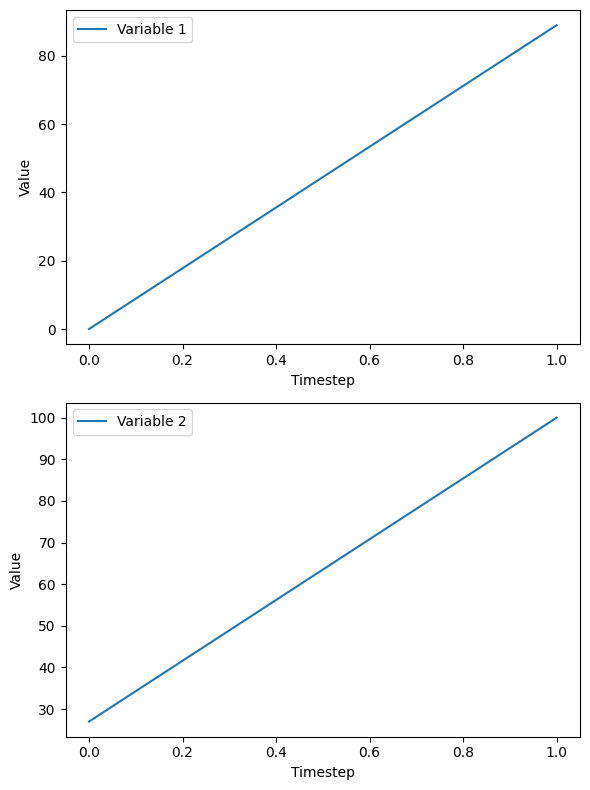

In [ ]:
import matplotlib.pyplot as plt

sample_id = 1
original_sample = X[sample_id]

# Number of timesteps and variables (or dimensions) in the multivariate time series
num_vars, num_timesteps = original_sample.shape

plt.figure(figsize=(6, 4 * num_vars))

# Plotting each variable
for i in range(num_vars):
    plt.subplot(num_vars, 1, i + 1)
    plt.plot(original_sample[:, i], label=f"Variable {i + 1}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    # Optionally add a grid: plt.grid()

plt.tight_layout()
plt.show()












In [ ]:
y[10]

'9'

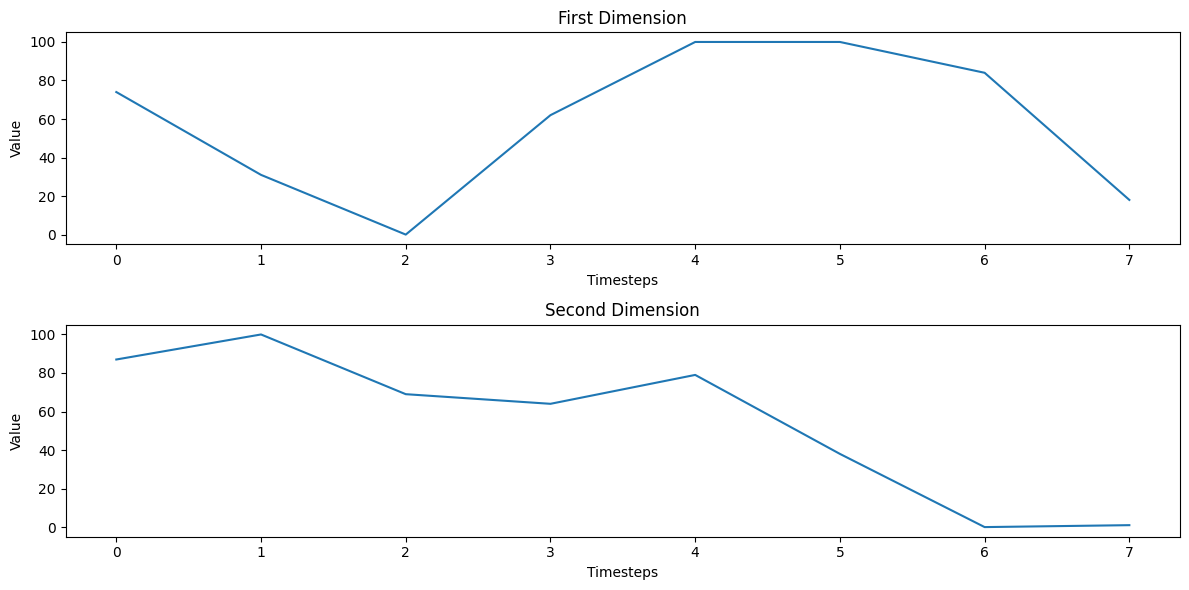

In [ ]:
import matplotlib.pyplot as plt

# Let's choose a specific series index, for instance, the 5th series
index = 10

# Extract the data for that series
chosen_series = X[index]

# The chosen series should have a shape similar to (2, timesteps)
dimension_1 = chosen_series[0]  # First variable or dimension
dimension_2 = chosen_series[1]  # Second variable or dimension

# Plotting
plt.figure(figsize=(12, 6))

# Plot first dimension
plt.subplot(2, 1, 1)
plt.plot(dimension_1)
plt.title('First Dimension')
plt.xlabel('Timesteps')
plt.ylabel('Value')

# Plot second dimension
plt.subplot(2, 1, 2)
plt.plot(dimension_2)
plt.title('Second Dimension')
plt.xlabel('Timesteps')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [37]:
idx = 1
y[idx]

'1'

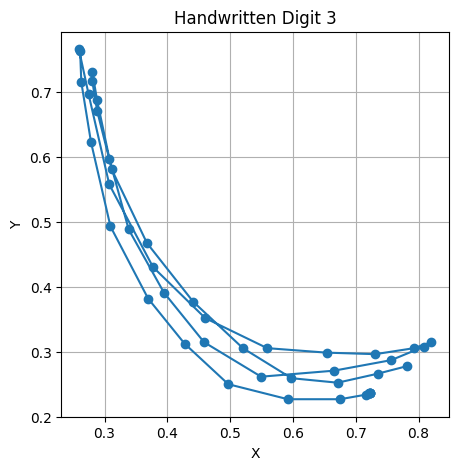

In [38]:
x_coords = X[idx,0]
y_coords = X[idx,1]
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.plot(x_coords, y_coords, marker='o', linestyle='-')
plt.title("Handwritten Digit 3")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

# Display the plot
plt.show()


 1: curved swing
		-- 2: horizontal swing
		-- 3: vertical swing
		-- 4: anti-clockwise arc
		-- 5: clockwise arc
		-- 6: circle
		-- 7: horizontal straight-line
		-- 8: vertical straight-line
		-- 9: horizontal zigzag
		-- 10: vertical zigzag
		-- 11: horizontal wavy
		-- 12: vertical wavy
		-- 13: face-up curve
		-- 14: face-down curve
		-- 15: tremble


In [19]:
y

array(['21.0', '22.0', '22.0', '17.0', '17.0', '7.0', '13.0', '22.0',
       '3.0', '26.0', '6.0', '15.0', '20.0', '5.0', '10.0', '1.0', '2.0',
       '25.0', '16.0', '8.0', '1.0', '20.0', '15.0', '3.0', '22.0', '2.0',
       '19.0', '4.0', '8.0', '21.0', '15.0', '17.0', '22.0', '1.0', '3.0',
       '26.0', '25.0', '2.0', '5.0', '12.0', '10.0', '3.0', '15.0', '5.0',
       '11.0', '22.0', '14.0', '7.0', '25.0', '18.0', '6.0', '10.0',
       '3.0', '15.0', '24.0', '25.0', '13.0', '13.0', '15.0', '6.0',
       '4.0', '4.0', '10.0', '20.0', '16.0', '26.0', '26.0', '6.0', '5.0',
       '12.0', '10.0', '23.0', '21.0', '1.0', '25.0', '1.0', '7.0', '9.0',
       '1.0', '23.0', '17.0', '2.0', '16.0', '20.0', '22.0', '25.0',
       '3.0', '22.0', '1.0', '19.0', '11.0', '7.0', '5.0', '12.0', '12.0',
       '6.0', '26.0', '3.0', '6.0', '23.0', '19.0', '13.0', '26.0', '9.0',
       '4.0', '22.0', '18.0', '9.0', '15.0', '7.0', '23.0', '14.0',
       '26.0', '21.0', '3.0', '20.0', '13.0', '2.0', '18

In [20]:
idx =15
y[idx]

'1.0'

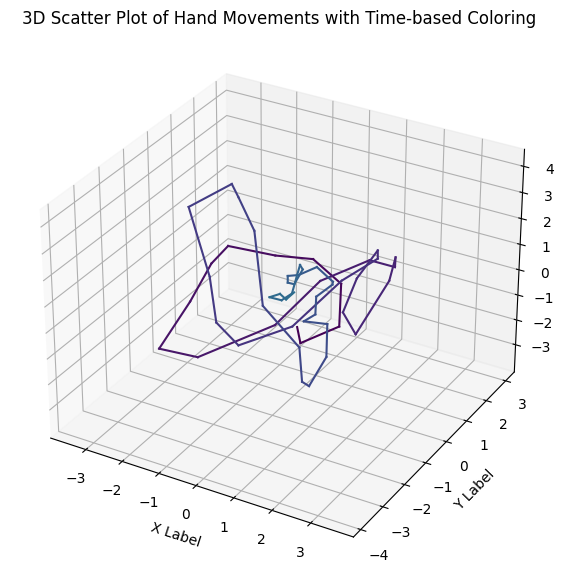

In [21]:
X_idx=X[idx,0]
Y_idx=X[idx,1]
Z_idx=X[idx,2]
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a color map to indicate time
n_points = len(X_idx)
colors = plt.cm.viridis(np.linspace(0, 1, n_points))

# Plot the points with color based on time
for i in range(n_points-1):
    ax.plot(X_idx[i:i+2], Y_idx[i:i+2], Z_idx[i:i+2], c=colors[i])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot of Hand Movements with Time-based Coloring')

# Show the plot
plt.show()
###


In [26]:
idx =15


y[idx]

'1.0'

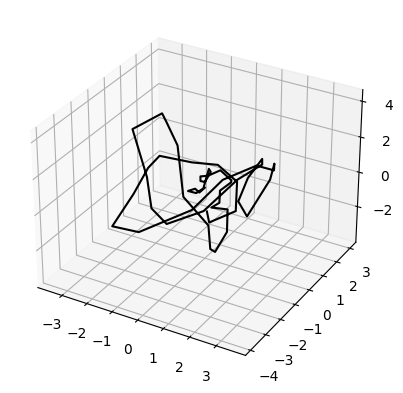

In [27]:
ax = plt.axes(projection='3d')
X_idx=X[idx,0]
Y_idx=X[idx,1]
Z_idx=X[idx,2]
# Data for a three-dimensional line
zline = Z_idx
xline = X_idx
yline = Y_idx
ax.plot3D(xline, yline, zline, 'black')



In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def normalize_multivariate(data, n_timesteps, n_features, scaler=None):

    # Then reshape data to have timesteps as rows for normalization
    data_reshaped = data.reshape(-1, n_features)

    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(data_reshaped)

    normalized = scaler.transform(data_reshaped)

    # Return data reshaped
    data = normalized.reshape(-1, n_timesteps, n_features)
    return data, scaler

def conditional_pad_multivariate(X):
    num_timesteps = X.shape[1]

    if num_timesteps % 4 != 0:
        next_num = (int(num_timesteps / 4) + 1) * 4
        padding_size = next_num - num_timesteps
        X_padded = np.pad(
            X, pad_width=((0, 0), (0, padding_size), (0, 0))
        )

        return X_padded, padding_size

    return X, 0



# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [ ]:
X,y,pos_label, neg_label = load_dataset('SelfRegulationSCP1')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

 Shape of X =  (561, 896, 6)
 Shape of y =  (561,)
 Meta data =  {'problemname': 'selfregulationscp1', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['negativity', 'positivity']}

 X[:1] = 
[[[23.   19.03 32.19 43.66 30.72 39.09]
  [21.66 19.19 36.81 41.22 31.81 39.53]
  [20.84 21.5  40.16 39.69 31.69 40.59]
  ...
  [21.84 27.03 32.5  50.06 44.69 44.03]
  [22.62 26.78 34.53 50.84 43.69 44.75]
  [21.5  28.94 37.12 50.75 41.88 46.19]]]


In [ ]:
# Upsample the minority class

pos_counts = pd.value_counts(y_train)[pos_label]
neg_counts = pd.value_counts(y_train)[neg_label]
print(f"negative_count = {neg_counts}, positive_count = {pos_counts}")

if pos_counts!=neg_counts:
  X_train, y_train = upsample_minority(X_train, y_train, pos_label=pos_label, neg_label=neg_label)
  print(f"Data upsampling performed, current distribution of y: \n{pd.value_counts(y_train)}.")
else:
   print(f"Data upsampling not needed, current distribution of y: \n{pd.value_counts(y_train)}.")


negative_count = 225, positive_count = 223
Data upsampling performed, current distribution of y: 
0    225
1    225
dtype: int64.


In [ ]:
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")

y_train_classes = y_train
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

Data pre-processed, original #timesteps=896, padded #timesteps=896.

min value = -73.84, max value = 175.06
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (450, 896, 6)
X_train_processed_padded.shape = (450, 896, 6)


In [ ]:
from keras.regularizers import l2
def Classifier(
    n_timesteps, n_features, n_conv_layers=1, add_dense_layer=True, n_output=1,input_format_stf=True
):
    # https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
    if input_format_stf:
      input_shape = (n_timesteps, n_features)
    else:
      input_shape = (n_features, n_timesteps)
    inputs = keras.Input(shape=input_shape, dtype="float32")


    if add_dense_layer:
        x = keras.layers.Dense(128)(inputs)
    else:
        x = inputs

    for i in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier
def LSTMFCNClassifier(n_timesteps, n_features, n_output=2, n_LSTM_cells=8, regularization_rate = 0.001,input_format_stf=True):
    # https://github.com/titu1994/LSTM-FCN/blob/master/hyperparameter_search.py
    if input_format_stf:
      input_shape = (n_timesteps, n_features)
    else:
      input_shape = (n_features, n_timesteps)
    inputs = keras.Input(shape=input_shape, dtype="float32")

    x = keras.layers.LSTM(units=n_LSTM_cells, kernel_regularizer=l2(regularization_rate))(inputs)
    x = keras.layers.Dropout(rate=0.8)(x)

    y = keras.layers.Permute((2, 1))(inputs)
    y = keras.layers.Conv1D(64, 8, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.Conv1D(128, 5, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.Conv1D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(regularization_rate))(y)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)

    y = keras.layers.GlobalAveragePooling1D()(y)

    x = keras.layers.concatenate([x, y])

    outputs = keras.layers.Dense(n_output, activation="softmax", kernel_regularizer=l2(regularization_rate))(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

def ClassifierLSTM(n_timesteps, n_features, extra_lstm_layer=True, n_output=1, input_format_stf = True):
    # Define the model structure - only LSTM layers
    # https://www.kaggle.com/szaitseff/classification-of-time-series-with-lstm-rnn

    if input_format_stf:
      input_shape = (n_timesteps, n_features)
    else:
      input_shape = (n_features, n_timesteps)
    inputs = keras.Input(shape=input_shape, dtype="float32")

    if extra_lstm_layer:
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(
            inputs
        )  # set return_sequences true to feed next LSTM layer
    else:
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(
            inputs
        )  # set return_sequences false to feed dense layer directly
    x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.LSTM(32, activation='tanh', return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    if extra_lstm_layer:
        x = keras.layers.LSTM(16, activation="tanh", return_sequences=False)(x)
        x = keras.layers.BatchNormalization()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier2 = keras.Model(inputs, outputs)

    return classifier2

def Classifier_FCN(input_shape, nb_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation="relu")(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation("relu")(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation("relu")(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(nb_classes, activation="softmax")(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

def EnhancedClassifier(
    n_timesteps,
    n_features,
    n_conv_layers=2,
    add_dense_layer=True,
    n_output=1,
    input_format_stf=True # if True, input is (series, features, timesteps); otherwise (series, timesteps, features)
):
    # Choose input shape based on the flag
    if input_format_stf:
      input_shape = (n_features, n_timesteps)
    else:
      input_shape = (n_timesteps, n_features)

    inputs = keras.Input(shape=input_shape, dtype="float32")

    if add_dense_layer:
        x = keras.layers.TimeDistributed(keras.layers.Dense(128))(x)

    for _ in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation="relu")(x) # Additional dense layer for complexity

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier = keras.models.Model(inputs=inputs, outputs=outputs)

    return classifier

In [ ]:
X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

In [ ]:
X_train_processed_padded.shape

(450, 896, 6)

In [ ]:
X_test_processed_padded.shape

(113, 896, 6)

In [ ]:
INPUT_FORMAT_STF = True
if INPUT_FORMAT_STF == False:
  X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
  X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

n_lstmcells = 8
# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ## 2.0 LSTM-FCN classifier
###############################################
# ### LSTM-FCN classifier
LSTMFCNclassifier = LSTMFCNClassifier(
    n_timesteps_padded, n_features, n_output=2, n_LSTM_cells=n_lstmcells,input_format_stf=INPUT_FORMAT_STF
)

optimizer = keras.optimizers.Adam(lr=0.0001)
LSTMFCNclassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = LSTMFCNclassifier.fit(
    X_train_processed_padded,
    y_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = LSTMFCNclassifier.predict(X_test_processed_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")

if INPUT_FORMAT_STF == False:
  X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
  X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

Training log for LSTM-FCN classifier:
Epoch 1/150
15/15 [==============================] - 8s 85ms/step - loss: 1.0165 - accuracy: 0.7733 - val_loss: 2.2895 - val_accuracy: 0.5044
Epoch 2/150
15/15 [==============================] - 1s 34ms/step - loss: 0.8766 - accuracy: 0.8467 - val_loss: 1.5305 - val_accuracy: 0.5310
Epoch 3/150
15/15 [==============================] - 0s 33ms/step - loss: 0.8388 - accuracy: 0.8489 - val_loss: 1.4171 - val_accuracy: 0.5487
Epoch 4/150
15/15 [==============================] - 1s 36ms/step - loss: 0.7627 - accuracy: 0.8578 - val_loss: 1.0453 - val_accuracy: 0.5841
Epoch 5/150
15/15 [==============================] - 1s 34ms/step - loss: 0.7662 - accuracy: 0.8689 - val_loss: 1.9389 - val_accuracy: 0.5310
Epoch 6/150
15/15 [==============================] - 1s 35ms/step - loss: 0.6856 - accuracy: 0.8822 - val_loss: 0.9491 - val_accuracy: 0.6991
Epoch 7/150
15/15 [==============================] - 1s 35ms/step - loss: 0.6406 - accuracy: 0.8844 - val_loss

In [ ]:

INPUT_FORMAT_STF = False

reset_seeds()
###############################################
# ### LSTM classifier
if INPUT_FORMAT_STF == False:
    X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
    X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

classifierLSTM = ClassifierLSTM(n_timesteps_padded, n_features,extra_lstm_layer=True, n_output=2, input_format_stf=INPUT_FORMAT_STF)

optimizer = keras.optimizers.Adam(lr=0.001)
classifierLSTM.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM classifier:")
classifier_history = classifierLSTM.fit(
    X_train_processed_padded,
    y_train,
    epochs=150,
    batch_size=42,
    shuffle=True,
    verbose=2,
    validation_data=(X_test_processed_padded, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifierLSTM.predict(X_test_processed_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")
if INPUT_FORMAT_STF == False:
  X_train_processed_padded = X_train_processed_padded.transpose(0,2,1)
  X_test_processed_padded = X_test_processed_padded.transpose(0,2,1)

Training log for LSTM classifier:
Epoch 1/150
11/11 - 6s - loss: 0.4475 - accuracy: 0.8244 - val_loss: 0.6779 - val_accuracy: 0.5044 - 6s/epoch - 526ms/step
Epoch 2/150
11/11 - 0s - loss: 0.3421 - accuracy: 0.8556 - val_loss: 0.6656 - val_accuracy: 0.5841 - 122ms/epoch - 11ms/step
Epoch 3/150
11/11 - 0s - loss: 0.2951 - accuracy: 0.8756 - val_loss: 0.6597 - val_accuracy: 0.7434 - 121ms/epoch - 11ms/step
Epoch 4/150
11/11 - 0s - loss: 0.2900 - accuracy: 0.8733 - val_loss: 0.6604 - val_accuracy: 0.6814 - 122ms/epoch - 11ms/step
Epoch 5/150
11/11 - 0s - loss: 0.2743 - accuracy: 0.8956 - val_loss: 0.6405 - val_accuracy: 0.7876 - 132ms/epoch - 12ms/step
Epoch 6/150
11/11 - 0s - loss: 0.2483 - accuracy: 0.8978 - val_loss: 0.6588 - val_accuracy: 0.5133 - 125ms/epoch - 11ms/step
Epoch 7/150
11/11 - 0s - loss: 0.2318 - accuracy: 0.9089 - val_loss: 0.6475 - val_accuracy: 0.5487 - 142ms/epoch - 13ms/step
Epoch 8/150
11/11 - 0s - loss: 0.2248 - accuracy: 0.9133 - val_loss: 0.6892 - val_accuracy: 0

In [ ]:
def Autoencoder(n_timesteps, n_features):
    # Define encoder and decoder structure
    def Encoder(input):
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(x)
        x = keras.layers.MaxPool1D(pool_size=2, padding="same")(x)
        return x

    def Decoder(input):
        x = keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        )(input)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=64, kernel_size=3, activation="relu", padding="same"
        )(x)
        # x = keras.layers.Conv1D(filters=64, kernel_size=2, activation="relu")(x)
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.Conv1D(
            filters=1, kernel_size=3, activation="linear", padding="same"
        )(x)
        return x

    # Define the AE model
    orig_input = keras.Input(shape=(n_timesteps,n_features))
    autoencoder = keras.Model(inputs=orig_input, outputs=Decoder(Encoder(orig_input)))

    return autoencoder

def AutoencoderLSTM(n_timesteps, n_features):
    # Define encoder and decoder structure
    # structure from medium post: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
    def EncoderLSTM(input):
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(input)
        # encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(x)
        encoded = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(x)
        return encoded

    def DecoderLSTM(encoded):
        x = keras.layers.RepeatVector(n_timesteps)(encoded)
        # x = keras.layers.LSTM(32, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=True)(x)
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(x)
        decoded = keras.layers.TimeDistributed(
            keras.layers.Dense(n_features, activation="sigmoid")
        )(x)
        return decoded

    # Define the AE model
    orig_input2 = keras.Input(shape=( n_timesteps,n_features))

    autoencoder2 = keras.Model(
        inputs=orig_input2, outputs=DecoderLSTM(EncoderLSTM(orig_input2))
    )

    return autoencoder2



In [ ]:
X_train_processed_padded.shape

(450, 896, 6)

In [ ]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features )
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=2,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Training log for 1dCNN autoencoder:
Epoch 1/50
15/15 - 6s - loss: 0.0616 - val_loss: 0.0144 - 6s/epoch - 377ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0046 - val_loss: 0.0013 - 394ms/epoch - 26ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0016 - val_loss: 0.0014 - 339ms/epoch - 23ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0011 - val_loss: 0.0011 - 416ms/epoch - 28ms/step
Epoch 5/50
15/15 - 0s - loss: 8.5874e-04 - val_loss: 6.6260e-04 - 367ms/epoch - 24ms/step
Epoch 6/50
15/15 - 0s - loss: 6.2007e-04 - val_loss: 6.1036e-04 - 390ms/epoch - 26ms/step
Epoch 7/50
15/15 - 0s - loss: 5.8653e-04 - val_loss: 5.9504e-04 - 356ms/epoch - 24ms/step
Epoch 8/50
15/15 - 0s - loss: 5.7407e-04 - val_loss: 5.8598e-04 - 379ms/epoch - 25ms/step
Epoch 9/50
15/15 - 0s - loss: 5.6770e-04 - val_loss: 5.8126e-04 - 396ms/epoch - 26ms/step
Epoch 10/50
15/15 - 0s - loss: 5.6435e-04 - val_loss: 5.7918e-04 - 405ms/epoch - 27ms/step
1dCNN autoencoder trained, with validation loss: 0.0005791778094135225.


In [ ]:
reset_seeds()
# ### 1dCNN autoencoder
autoencoderLSTM = AutoencoderLSTM(n_timesteps_padded, n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoderLSTM.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoderLSTM.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=2,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")

Training log for 1dCNN autoencoder:
Epoch 1/50
15/15 - 14s - loss: 0.0197 - val_loss: 0.0089 - 14s/epoch - 904ms/step
Epoch 2/50
15/15 - 2s - loss: 0.0110 - val_loss: 0.0086 - 2s/epoch - 138ms/step
Epoch 3/50
15/15 - 2s - loss: 0.0103 - val_loss: 0.0081 - 2s/epoch - 118ms/step
Epoch 4/50
15/15 - 2s - loss: 0.0098 - val_loss: 0.0079 - 2s/epoch - 105ms/step
Epoch 5/50
15/15 - 3s - loss: 0.0080 - val_loss: 0.0044 - 3s/epoch - 197ms/step
Epoch 6/50
15/15 - 3s - loss: 0.0058 - val_loss: 0.0044 - 3s/epoch - 229ms/step
Epoch 7/50
15/15 - 3s - loss: 0.0049 - val_loss: 0.0042 - 3s/epoch - 205ms/step
Epoch 8/50
15/15 - 2s - loss: 0.0043 - val_loss: 0.0040 - 2s/epoch - 105ms/step
Epoch 9/50
15/15 - 1s - loss: 0.0042 - val_loss: 0.0044 - 1s/epoch - 90ms/step
Epoch 10/50
15/15 - 1s - loss: 0.0041 - val_loss: 0.0034 - 1s/epoch - 92ms/step
Epoch 11/50
15/15 - 1s - loss: 0.0043 - val_loss: 0.0033 - 1s/epoch - 91ms/step
Epoch 12/50
15/15 - 1s - loss: 0.0038 - val_loss: 0.0051 - 1s/epoch - 91ms/step
Epo

In [ ]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
from LIMESegment.Utils.explanations import LIMESegment
def get_global_weight_univariate(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, n_timesteps, n_dims = input_samples.shape  # n_dims=1

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps
            self.n_features_in_ = n_features

        def predict(self, X):
            p = self.model.predict(X.reshape(n_samples, n_timesteps, 1))
            return np.argmax(p, axis=1)

        def fit(self, X, y):

          self.fitted_ = True
          return self.model.fit(X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    i = IntervalImportance(scoring="accuracy",n_intervals=10, random_state=random_state)
    i.fit(clf, input_samples.reshape(input_samples.shape[0], -1), input_labels)

    # calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, 1)
    return weighted_steps

In [ ]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate2
w_type = "global"

if w_type == "global":
    step_weights = get_global_weightstr(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][:10]
    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )

ValueError: ignored